In [1]:
#load the necessary functions
from __future__ import print_function
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pylab as pylab
import itertools
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import scipy
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.weight':'medium', 
         'xtick.major.size':8,
         'ytick.major.size':8}
pylab.rcParams.update(params)

/software/repo/python/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/software/repo/python/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

# PCA

In [2]:
#load the dcd file that has alignmentacarbons all the smaller dcd files
#these are all aligned to the alpha carbons
glycosylatedrep1 = md.load('../partial_glycosylation/trajectories/replicate1/no_lipids/alignmentacarbons.dcd', top='../partial_glycosylation/trajectories/replicate1/no_lipids/subset.pdb')
glycosylatedrep2 = md.load('../partial_glycosylation/trajectories/replicate2/no_lipids/alignmentacarbons.dcd', top='../partial_glycosylation/trajectories/replicate2/no_lipids/subset.pdb')
glycosylatedrep3 = md.load('../partial_glycosylation/trajectories/replicate3/no_lipids/alignmentacarbons.dcd', top='../partial_glycosylation/trajectories/replicate3/no_lipids/subset.pdb')
unglycosylatedrep1 = md.load('../no_glycosylation/replicate1/no_lipids/alignmentacarbons.dcd', top='../no_glycosylation/replicate1/no_lipids/subset.pdb')
unglycosylatedrep2 = md.load('../no_glycosylation/replicate2/no_lipids/alignmentacarbons.dcd', top='../no_glycosylation/replicate2/no_lipids/subset.pdb')
unglycosylatedrep3 = md.load('../no_glycosylation/replicate3/no_lipids/alignmentacarbons.dcd', top='../no_glycosylation/replicate3/no_lipids/subset.pdb')
virion = md.load('../whole_virion/alignmentacarbons.dcd', top='../whole_virion/subset.pdb')

/home/cseitz/.local/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/cseitz/.local/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


In [3]:
#eliminate the first frame since the whole system jumps there
glycosylatedrep1 = glycosylatedrep1[1:44100]
glycosylatedrep2 = glycosylatedrep2[1:44100]
glycosylatedrep3 = glycosylatedrep3[1:44100]
unglycosylatedrep1 = unglycosylatedrep1[1:44100]
unglycosylatedrep2 = unglycosylatedrep2[1:44100]
unglycosylatedrep3 = unglycosylatedrep3[1:44100]
virion = virion[1:7350]

In [4]:
pca1 = PCA(n_components=2)
reduced_cartesiang1 = pca1.fit_transform(glycosylatedrep1.xyz.reshape(glycosylatedrep1.n_frames, glycosylatedrep1.n_atoms * 3))
reduced_cartesiang2 = pca1.fit_transform(glycosylatedrep2.xyz.reshape(glycosylatedrep2.n_frames, glycosylatedrep2.n_atoms * 3))
reduced_cartesiang3 = pca1.fit_transform(glycosylatedrep3.xyz.reshape(glycosylatedrep3.n_frames, glycosylatedrep3.n_atoms * 3))
reduced_cartesiang1 = pca1.fit_transform(glycosylatedrep1.xyz.reshape(glycosylatedrep1.n_frames, glycosylatedrep1.n_atoms * 3))
reduced_cartesianu1 = pca1.fit_transform(unglycosylatedrep1.xyz.reshape(unglycosylatedrep1.n_frames, unglycosylatedrep1.n_atoms * 3))
reduced_cartesianu2 = pca1.fit_transform(unglycosylatedrep2.xyz.reshape(unglycosylatedrep2.n_frames, unglycosylatedrep2.n_atoms * 3))
reduced_cartesianu3 = pca1.fit_transform(unglycosylatedrep3.xyz.reshape(unglycosylatedrep3.n_frames, unglycosylatedrep3.n_atoms * 3))
reduced_cartesianv = pca1.fit_transform(virion.xyz.reshape(virion.n_frames, virion.n_atoms * 3))
print(reduced_cartesiang1.shape)

(44098, 2)


In [5]:
#cat the arrays for the density plots later
pca_glycosylated = np.concatenate([reduced_cartesiang1, reduced_cartesiang2, reduced_cartesiang3])
pca_unglycosylated = np.concatenate([reduced_cartesianu1, reduced_cartesianu2, reduced_cartesianu3])

In [30]:
#we want to calculate the eigenvalues from each of these trajectories
#create a covariance matrix for each system
covg1 = glycosylatedrep1.xyz.reshape(glycosylatedrep1.n_frames, glycosylatedrep1.n_atoms * 3)
covg2 = glycosylatedrep2.xyz.reshape(glycosylatedrep2.n_frames, glycosylatedrep2.n_atoms * 3)
covg3 = glycosylatedrep3.xyz.reshape(glycosylatedrep3.n_frames, glycosylatedrep3.n_atoms * 3)
covu1 = unglycosylatedrep1.xyz.reshape(unglycosylatedrep1.n_frames, unglycosylatedrep1.n_atoms * 3)
covu2 = unglycosylatedrep2.xyz.reshape(unglycosylatedrep2.n_frames, unglycosylatedrep2.n_atoms * 3)
covu3 = unglycosylatedrep3.xyz.reshape(unglycosylatedrep3.n_frames, unglycosylatedrep3.n_atoms * 3)
covv = virion.xyz.reshape(virion.n_frames, virion.n_atoms * 3)

#fit each of these covariance matrices to our two-component PCA object and print the eigenvalues
pca1.fit(covg1)
eigenvalueg1 = pca1.explained_variance_
print("The eigenvalues of g1 are:", eigenvalueg1)
pca1.fit(covg2)
eigenvalueg2 = pca1.explained_variance_
print("The eigenvalues of g2 are:", eigenvalueg2)
pca1.fit(covg3)
eigenvalueg3 = pca1.explained_variance_
print("The eigenvalues of g3 are:", eigenvalueg3)
pca1.fit(covu1)
eigenvalueu1 = pca1.explained_variance_
print("The eigenvalues of u1 are:", eigenvalueu1)
pca1.fit(covu2)
eigenvalueu2 = pca1.explained_variance_
print("The eigenvalues of u2 are:", eigenvalueu2)
pca1.fit(covu3)
eigenvalueu3 = pca1.explained_variance_
print("The eigenvalues of u3 are:", eigenvalueu3)
pca1.fit(covv)
eigenvaluev = pca1.explained_variance_
print("The eigenvalues of v are:", eigenvaluev)

The eigenvalues of g1 are: [7192.623  1187.3236]
The eigenvalues of g2 are: [6939.9136  996.45  ]
The eigenvalues of g3 are: [2316.6826 1261.2008]
The eigenvalues of u1 are: [7312.238  1024.4515]
The eigenvalues of u2 are: [3564.0198 1452.5596]
The eigenvalues of u3 are: [1374.1185 1112.2452]
The eigenvalues of v are: [4067.3318 1363.0508]


In [45]:
#next, we will use these eigenvalues to find the force constants defining the harmonic well in the direction of the first two eigenvalues
#the formula for this is k = k_BT/lambda, where k_B is the Boltzmann, T is 298 K, and lambda is each eigenvalue
k_B = 8.314462618e-3 #units of kJ/mol*K
T = 298 #units of K
#because the MD trajectories were made with coordinate data in Å, the unit of the eigenvalues is Å² (according to Prody)
#we want k to have units of nm² so we will multiply the eigenvalues λ by 10*10=100
well1g1 = (k_B*T)/(100*eigenvalueg1[0])
well2g1 = (k_B*T)/(100*eigenvalueg1[1])
well1g2 = (k_B*T)/(100*eigenvalueg2[0])
well2g2 = (k_B*T)/(100*eigenvalueg2[1])
well1g3 = (k_B*T)/(100*eigenvalueg3[0])
well2g3 = (k_B*T)/(100*eigenvalueg3[1])

well1u1 = (k_B*T)/(100*eigenvalueu1[0])
well2u1 = (k_B*T)/(100*eigenvalueu1[1])
well1u2 = (k_B*T)/(100*eigenvalueu2[0])
well2u2 = (k_B*T)/(100*eigenvalueu2[1])
well1u3 = (k_B*T)/(100*eigenvalueu3[0])
well2u3 = (k_B*T)/(100*eigenvalueu3[1])

well1v = (k_B*T)/(100*eigenvaluev[0])
well2v = (k_B*T)/(100*eigenvaluev[1])

wellg = np.array([well1g1, well1g2, well1g3])
wellg_avg = np.mean(wellg)
print("The k of PC1 for the glycosylated systems is", wellg_avg)


wellu = np.array([well1u1, well1u2, well1u3])
wellu_avg = np.mean(wellu)
print("The k of PC1 for the unglycosylated systems is", wellu_avg)

print("The k of PC1 for the virion system is", well1v)

The k of PC1 for the glycosylated systems is 5.903367189353929e-06
The k of PC1 for the unglycosylated systems is 9.457239776401196e-06
The k of PC1 for the virion system is 6.091732835803129e-06


In [6]:
#to show how much each PCA component contributes to the overall variance
#test some difference numbers of PCA components
#if you try 3 components and the 3rd hardly contributes, then use 2
ex_variance=np.var(reduced_cartesiang1,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)
ex_variance=np.var(reduced_cartesiang2,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)
ex_variance=np.var(reduced_cartesiang3,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)
ex_variance=np.var(reduced_cartesianu1,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)
ex_variance=np.var(reduced_cartesianu2,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)
ex_variance=np.var(reduced_cartesianu3,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)
ex_variance=np.var(reduced_cartesianv,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

[0.85831344 0.14168663]
[0.8744448  0.12555525]
[0.6475016  0.35249844]
[0.8771159  0.12288408]
[0.7104469 0.2895531]
[0.5526642  0.44733572]
[0.7489956  0.25100443]


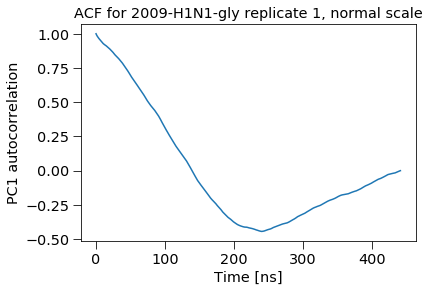

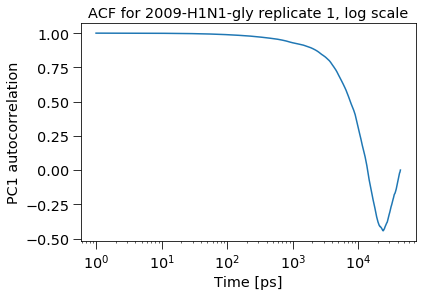

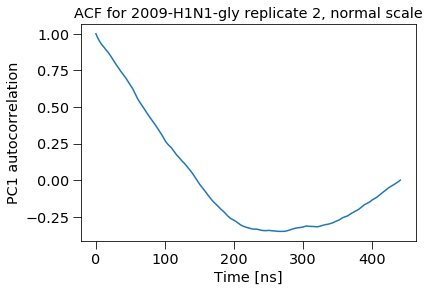

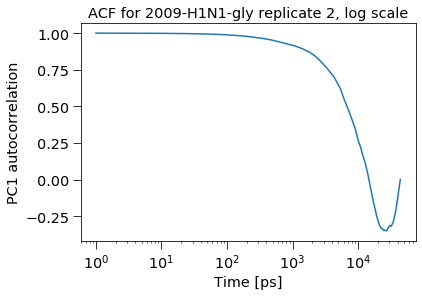

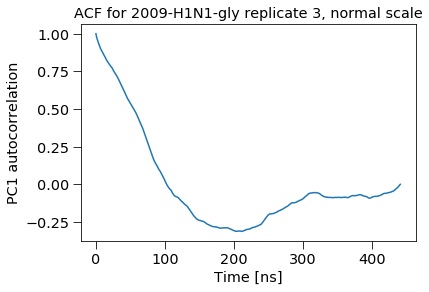

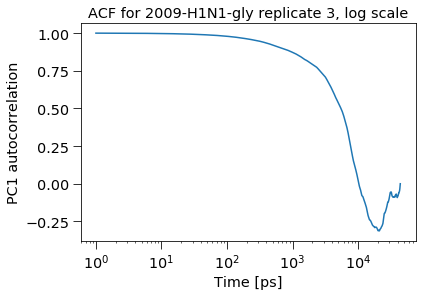

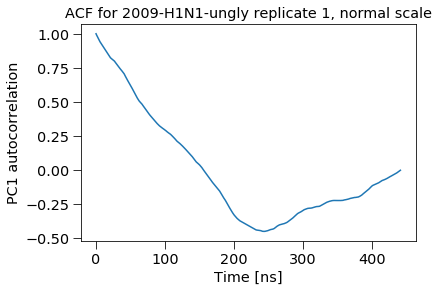

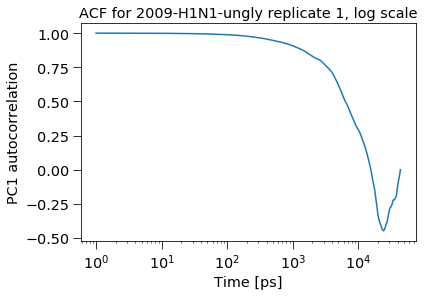

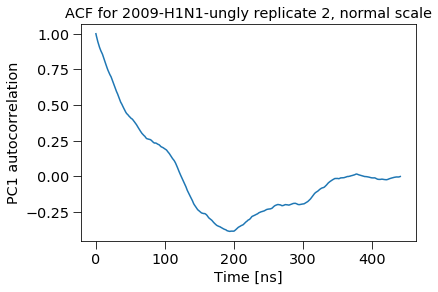

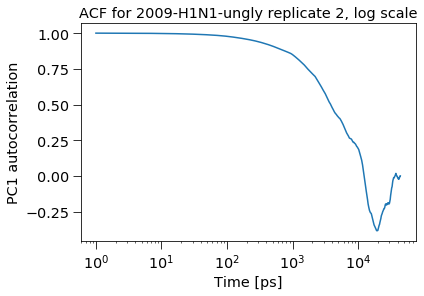

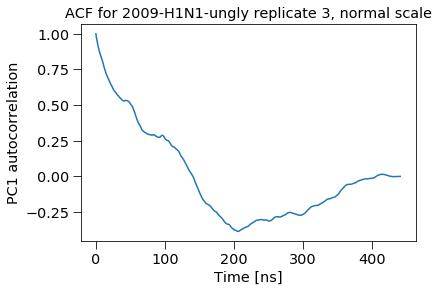

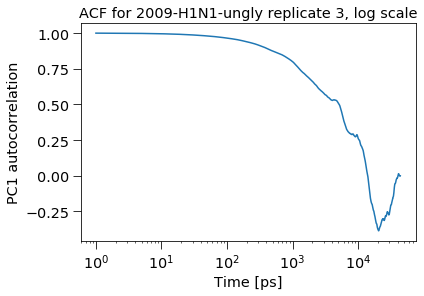

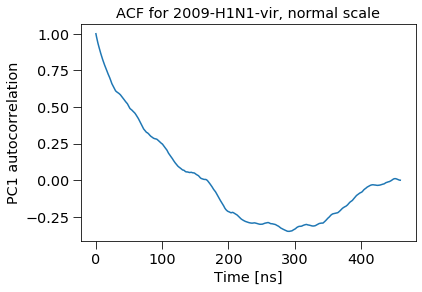

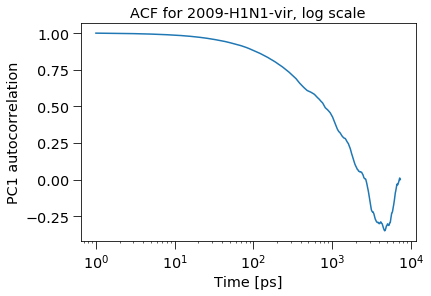

In [69]:
#define the autocorrelation function
def autocorr(x):
    "Compute autocorrelation with numpy"
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]
    return result / result[0]

#normal scale
plt.plot(glycosylatedrep1.time/100, autocorr(reduced_cartesiang1[:,0]))
plt.xlabel('Time [ns]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-gly replicate 1, normal scale')
plt.show()

#log scale
plt.semilogx(glycosylatedrep1.time, autocorr(reduced_cartesiang1[:,0]))
plt.xlabel('Time [ps]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-gly replicate 1, log scale')
plt.show()

plt.plot(glycosylatedrep2.time/100, autocorr(reduced_cartesiang2[:,0]))
plt.xlabel('Time [ns]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-gly replicate 2, normal scale')
plt.show()
plt.semilogx(glycosylatedrep2.time, autocorr(reduced_cartesiang2[:,0]))
plt.xlabel('Time [ps]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-gly replicate 2, log scale')
plt.show()

plt.plot(glycosylatedrep3.time/100, autocorr(reduced_cartesiang3[:,0]))
plt.xlabel('Time [ns]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-gly replicate 3, normal scale')
plt.show()
plt.semilogx(glycosylatedrep3.time, autocorr(reduced_cartesiang3[:,0]))
plt.xlabel('Time [ps]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-gly replicate 3, log scale')
plt.show()

plt.plot(unglycosylatedrep1.time/100, autocorr(reduced_cartesianu1[:,0]))
plt.xlabel('Time [ns]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-ungly replicate 1, normal scale')
plt.show()
plt.semilogx(unglycosylatedrep1.time, autocorr(reduced_cartesianu1[:,0]))
plt.xlabel('Time [ps]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-ungly replicate 1, log scale')
plt.show()

plt.plot(unglycosylatedrep2.time/100, autocorr(reduced_cartesianu2[:,0]))
plt.xlabel('Time [ns]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-ungly replicate 2, normal scale')
plt.show()
plt.semilogx(unglycosylatedrep2.time, autocorr(reduced_cartesianu2[:,0]))
plt.xlabel('Time [ps]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-ungly replicate 2, log scale')
plt.show()

plt.plot(unglycosylatedrep3.time/100, autocorr(reduced_cartesianu3[:,0]))
plt.xlabel('Time [ns]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-ungly replicate 3, normal scale')
plt.show()
plt.semilogx(unglycosylatedrep3.time, autocorr(reduced_cartesianu3[:,0]))
plt.xlabel('Time [ps]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-ungly replicate 3, log scale')
plt.show()

plt.plot(virion.time/16, autocorr(reduced_cartesianv[:,0]))
plt.xlabel('Time [ns]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-vir, normal scale')
plt.show()
plt.semilogx(virion.time, autocorr(reduced_cartesianv[:,0]))
plt.xlabel('Time [ps]')
plt.ylabel('PC1 autocorrelation')
plt.title('ACF for 2009-H1N1-vir, log scale')
plt.show()

In [14]:
#define the exponential equation we want to solve
def exponential(x, a, k):
    return a*np.exp(x*k)

In [88]:
#fit the autocorrelation function to the exponential
#note that the bounds on a are (0, infinity) and the bounds on k are (-infinity, 0)
#this is because a cannot be negative, and k cannot be positive (according to our physical system and the exponential equation we are trying to solve)
#we have also converted the systems into x_data of ps, as we want that for our final results

#multiply each by 10 and the virion by 60 to get ps but I think I want ns
#divide each by 100 and divide virion by 16 to get ns?
poptg1, pcovg1 = scipy.optimize.curve_fit(exponential, glycosylatedrep1.time/100, autocorr(reduced_cartesiang1[:,0]), bounds=([0, -np.inf], [np.inf, 0]))
poptg2, pcovg2 = scipy.optimize.curve_fit(exponential, glycosylatedrep2.time/100, autocorr(reduced_cartesiang2[:,0]), bounds=([0, -np.inf], [np.inf, 0]))
poptg3, pcovg3 = scipy.optimize.curve_fit(exponential, glycosylatedrep3.time/100, autocorr(reduced_cartesiang3[:,0]), bounds=([0, -np.inf], [np.inf, 0]))
poptu1, pcovu1 = scipy.optimize.curve_fit(exponential, unglycosylatedrep1.time/100, autocorr(reduced_cartesianu1[:,0]), bounds=([0, -np.inf], [np.inf, 0]))
poptu2, pcovu2 = scipy.optimize.curve_fit(exponential, unglycosylatedrep2.time/100, autocorr(reduced_cartesianu2[:,0]), bounds=([0, -np.inf], [np.inf, 0]))
poptu3, pcovu3 = scipy.optimize.curve_fit(exponential, unglycosylatedrep3.time/100, autocorr(reduced_cartesianu3[:,0]), bounds=([0, -np.inf], [np.inf, 0]))
poptv, pcovv = scipy.optimize.curve_fit(exponential, virion.time/16, autocorr(reduced_cartesianv[:,0]), bounds=([0, -np.inf], [np.inf, 0]))

#separate the independent variables
ag1 = poptg1[0]
ag2 = poptg2[0]
ag3 = poptg3[0]
au1 = poptu1[0]
au2 = poptu2[0]
au3 = poptu3[0]
av = poptv[0]

kg1 = poptg1[1]
kg2 = poptg2[1]
kg3 = poptg3[1]
ku1 = poptu1[1]
ku2 = poptu2[1]
ku3 = poptu3[1]
kv = poptv[1]

#extract tau from the independent variable k
#k = (-1/tau)
taug1 = -1/kg1
taug2 = -1/kg2
taug3 = -1/kg3
tauu1 = -1/ku1
tauu2 = -1/ku2
tauu3 = -1/ku3
tauv = -1/kv

#derive zeta; zeta = k*tau where k is the k from the k from the wells calculated earlier, it is NOT the k from this cell
#also we want our units to be amu/ns so we need to multiply the answer by 1000*1000
zetag1 = well1g1*taug1*1000000
zetag2 = well1g2*taug2*1000000
zetag3 = well1g3*taug3*1000000
zetau1 = well1u1*taug1*1000000
zetau2 = well1u2*tauu2*1000000
zetau3 = well1u3*tauu3*1000000
zetav = well1v*tauv*1000000

#average the a, tau and zeta variables across systems
a_g = np.array([ag1, ag2, ag3])
a_avg_g = np.mean(a_g)
print("The a of PC1 for the glycosylated systems is", a_avg_g)
tau_g = np.array([taug1, taug2, taug3])
tau_avg_g = np.mean(tau_g)
print("The tau of PC1 for the glycosylated systems is", tau_avg_g)
zeta_g = np.array([zetag1, zetag2, zetag3])
zeta_avg_g = np.mean(zeta_g)
print("The zeta of PC1 for the glycosylated systems is", zeta_avg_g)

a_u = np.array([au1, au2, au3])
a_avg_u = np.mean(a_u)
print("The a of PC1 for the unglycosylated systems is", a_avg_u)
tau_u = np.array([tauu1, tauu2, tauu3])
tau_avg_u = np.mean(tau_u)
print("The tau of PC1 for the unglycosylated systems is", tau_avg_u)
zeta_u = np.array([zetau1, zetau2, zetau3])
zeta_avg_u = np.mean(zeta_u)
print("The zeta of PC1 for the unglycosylated systems is", zeta_avg_u)

print("The a of PC1 for the virion system is", av)
print("The tau of PC1 for the virion system is", tauv)
print("The zeta of PC1 for the virion system is", zetav)

The a of PC1 for the glycosylated systems is 1.2783112922622337
The tau of PC1 for the glycosylated systems is 48.66680671789629
The zeta of PC1 for the glycosylated systems is 267.5536881055919
The a of PC1 for the unglycosylated systems is 1.1540394389503779
The tau of PC1 for the unglycosylated systems is 47.068693097678846
The zeta of PC1 for the unglycosylated systems is 437.8117053819654
The a of PC1 for the virion system is 1.092826008253677
The tau of PC1 for the virion system is 51.43722964536621
The zeta of PC1 for the virion system is 313.34186081342347


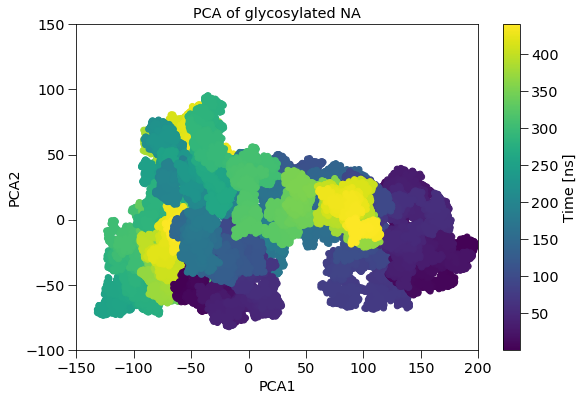

In [7]:
#gets the PCA of the alpha carbons in the glycosylated system
#plt.figure(figsize=(9,6))
#plt.scatter(reduced_cartesiang1[:,0], reduced_cartesiang1[:,1], marker='o', c=glycosylatedrep1.time*0.01)
#plt.scatter(reduced_cartesiang2[:,0], reduced_cartesiang2[:,1], marker='o', c=glycosylatedrep2.time*0.01)
#plt.scatter(reduced_cartesiang3[:,0], reduced_cartesiang3[:,1], marker='o', c=glycosylatedrep3.time*0.01)
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.xlim(-150, 200)
#plt.ylim(-100, 150)
#plt.title('PCA of glycosylated NA')
#cbar = plt.colorbar()
#cbar.set_label('Time [ns]')
#plt.savefig('pca_glycosylated.png')
#plt.show()

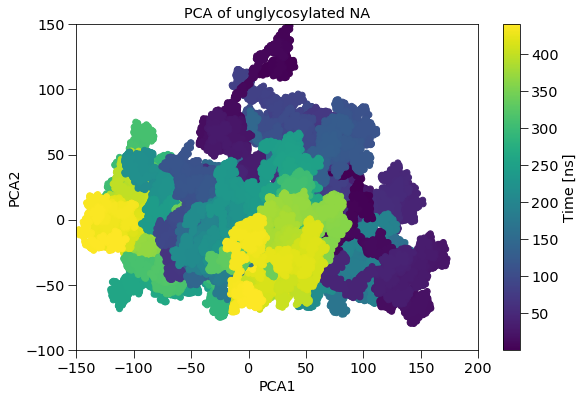

In [8]:
#gets the PCA of the alpha carbons in the unglycosylated system
#plt.figure(figsize=(9,6))
#plt.scatter(reduced_cartesianu1[:,0], reduced_cartesianu1[:,1], marker='o', c=unglycosylatedrep1.time*0.01)
#plt.scatter(reduced_cartesianu2[:,0], reduced_cartesianu2[:,1], marker='o', c=unglycosylatedrep2.time*0.01)
#plt.scatter(reduced_cartesianu3[:,0], reduced_cartesianu3[:,1], marker='o', c=unglycosylatedrep3.time*0.01)
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.xlim(-150, 200)
#plt.ylim(-100, 150)
#plt.title('PCA of unglycosylated NA')
#cbar = plt.colorbar()
#cbar.set_label('Time [ns]')
#plt.savefig('pca_unglycosylated.png')
#plt.show()

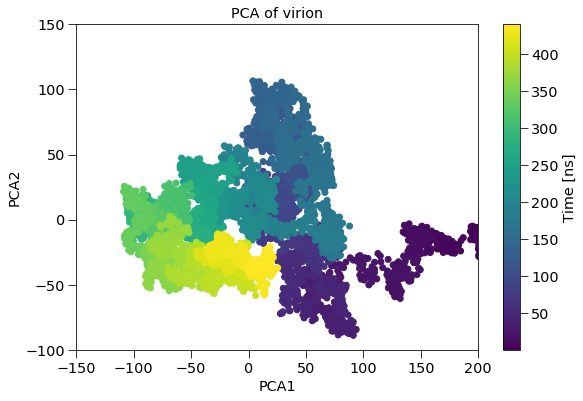

In [9]:
#gets the PCA of the alpha carbons in the virion
#plt.figure(figsize=(9,6))
#plt.scatter(reduced_cartesianv[:,0], reduced_cartesianv[:,1], marker='o', c=virion.time*0.06)
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.xlim(-150, 200)
#plt.ylim(-100, 150)
#plt.title('PCA of virion')
#cbar = plt.colorbar()
#cbar.set_label('Time [ns]')
#plt.savefig('pca_virion.png')
#plt.show()

In [89]:
#pca1 = PCA(n_components=2)
#reduced_cartesian = pca1.fit_transform(alignmentacarbons.xyz.reshape(alignmentacarbons.n_frames, alignmentacarbons.n_atoms * 3))
#print(reduced_cartesian.shape)

In [ ]:
#plt.figure()
#plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='o', c=alignmentacarbons.time)
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#cbar = plt.colorbar()
#cbar.set_label('Time [ps]')
#plt.savefig('pca_acarbons.png')

In [ ]:
#pca1 = PCA(n_components=2)
#reduced_cartesian = pca1.fit_transform(alignmentresidall.xyz.reshape(alignmentresidall.n_frames, alignmentresidall.n_atoms * 3))
#print(reduced_cartesian.shape)

In [ ]:
#plt.figure()
#plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='o', c=alignmentresidall.time)
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#cbar = plt.colorbar()
#cbar.set_label('Time [ps]')
#plt.savefig('pca_residall.png')

In [11]:
#def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
#    """
#    Scatter plot colored by 2d histogram
#    """
#    if ax is None :
#        fig , ax = plt.subplots()
#    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
#    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
#    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
#    if sort :
#        idx = z.argsort()
#        x, y, z = x[idx], y[idx], z[idx]

#    ax.scatter( x, y, c=z, **kwargs )

#    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
#    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
#    cbar.set_ticks([])
#    cbar.ax.set_ylabel('Density')

#    return ax

<Figure size 432x288 with 0 Axes>

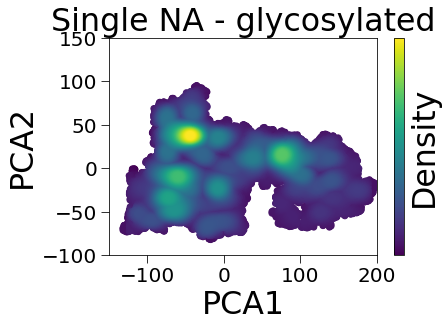

In [12]:
#PCA plot of the conformational space accessed as a function of density for the glycosylated systems
#plt.figure()
#plt.rc('xtick', labelsize=20)
#plt.rc('ytick', labelsize=20)
#plt.rcParams.update({'font.size': 22})
#density_scatter(pca_glycosylated[:, 0], pca_glycosylated[:, 1])
#plt.xlim([-150, 200])
#plt.ylim([-100, 150])
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.title('Single NA - glycosylated')
#plt.savefig('pca_density_glycosylated.png')

<Figure size 432x288 with 0 Axes>

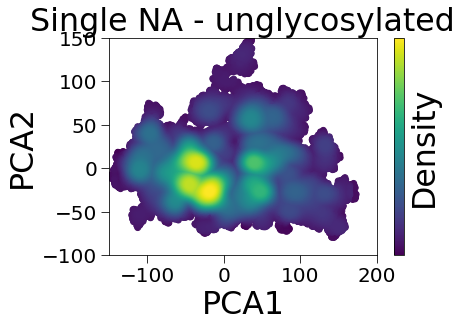

In [13]:
#PCA plot of the conformational space accessed as a function of density for the glycosylated systems
#plt.figure()
#plt.rc('xtick', labelsize=20)
#plt.rc('ytick', labelsize=20)
#plt.rcParams.update({'font.size': 22})
#density_scatter(pca_unglycosylated[:, 0], pca_unglycosylated[:, 1])
#plt.xlim([-150, 200])
#plt.ylim([-100, 150])
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.title('Single NA - unglycosylated')
#plt.savefig('pca_density_unglycosylated.png')

<Figure size 432x288 with 0 Axes>

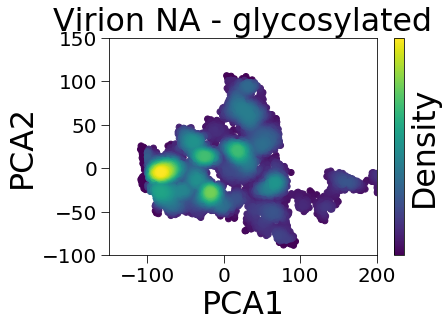

In [14]:
#PCA plot of the conformational space accessed as a function of density for the glycosylated systems
#plt.figure()
#plt.rc('xtick', labelsize=20)
#plt.rc('ytick', labelsize=20)
#plt.rcParams.update({'font.size': 22})
#density_scatter(reduced_cartesianv[:, 0], reduced_cartesianv[:, 1])
#plt.xlim([-150, 200])
#plt.ylim([-100, 150])
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.title('Virion NA - glycosylated')
#plt.savefig('pca_density_virion.png')

In [15]:
#this is all volume but will include pixels without stuff on them so we want a low cutoff
#h, xedges, yedges, _ = plt.hist2d(reduced_cartesiang1[:, 0], reduced_cartesiang1[:, 1],
#                                  bins=(20, 30), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("volume of glycosylated trajectory 1:", total_volume)
#plt.close()
#h, xedges, yedges, _ = plt.hist2d(reduced_cartesiang2[:, 0], reduced_cartesiang2[:, 1],
#                                  bins=(20, 30), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("volume of glycosylated trajectory 2:", total_volume)
#plt.close()
#h, xedges, yedges, _ = plt.hist2d(reduced_cartesiang3[:, 0], reduced_cartesiang3[:, 1],
#                                  bins=(20, 30), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("volume of glycosylated trajectory 3:", total_volume)
#plt.close()
#h, xedges, yedges, _ = plt.hist2d(pca_glycosylated[:, 0], pca_glycosylated[:, 1],
#                                  bins=(20, 30), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("total volume of glycosylated trajectories:", total_volume)
#plt.close()

#h, xedges, yedges, _ = plt.hist2d(reduced_cartesianu1[:, 0], reduced_cartesianu1[:, 1],
#                                  bins=(20, 30), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("volume of unglycosylated trajectory 1:", total_volume)
#plt.close()
#h, xedges, yedges, _ = plt.hist2d(reduced_cartesianu2[:, 0], reduced_cartesianu2[:, 1],
#                                  bins=(20, 30), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("volume of unglycosylated trajectory 2:", total_volume)
#plt.close()
#h, xedges, yedges, _ = plt.hist2d(reduced_cartesianu3[:, 0], reduced_cartesianu3[:, 1],
#                                  bins=(20, 30), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("volume of unglycosylated trajectory 3:", total_volume)
#plt.close()
#h, xedges, yedges, _ = plt.hist2d(pca_glycosylated[:, 0], pca_glycosylated[:, 1],
#                                  bins=(20, 30), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("total volume of unglycosylated trajectories:", total_volume)
#plt.close()


#h, xedges, yedges, _ = plt.hist2d(reduced_cartesianv[:, 0], reduced_cartesianv[:, 1],
#                                  bins=(2, 3), density=False)
#total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
#print("total volume of virion trajectory:", total_volume)
#plt.close()
#print("   predicted :", (xedges[-1] - xedges[0]) * (yedges[-1] - yedges[0]) / 600 * 1000)

volume of glycosylated trajectory 1: 3733811.4141663825
volume of glycosylated trajectory 2: 3044069.656325167
volume of glycosylated trajectory 3: 2553658.926134055
total volume of glycosylated trajectories: 12851186.863061566
volume of unglycosylated trajectory 1: 3657985.200250081
volume of unglycosylated trajectory 2: 4029958.1634596074
volume of unglycosylated trajectory 3: 2729212.961466005
total volume of unglycosylated trajectories: 12851186.863061566
total volume of virion trajectory: 80209320.96765001


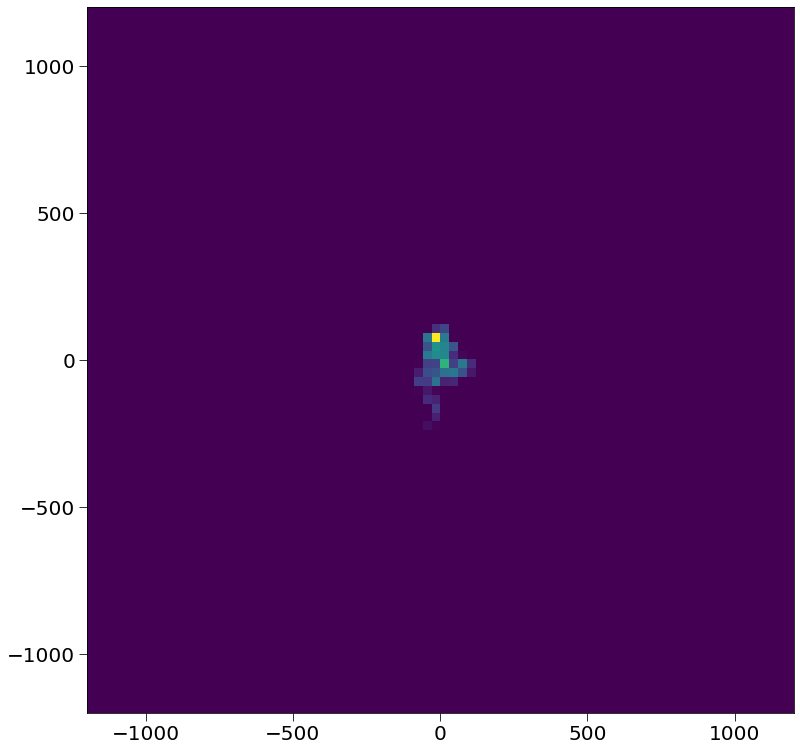

6613200.0


In [16]:
#PC1 = reduced_cartesianv[:,0]
#PC2 = reduced_cartesianv[:,1]
#hist, xedges, yedges = np.histogram2d(PC1, PC2, bins=80, range=[[-1200, 1200], [-1200, 1200]])
#area = hist.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
#ax = plt.figure(figsize=(15,13)).add_subplot(111)
#ax.imshow(
#    hist, interpolation='nearest',
#    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#plt.show()
#print(area)

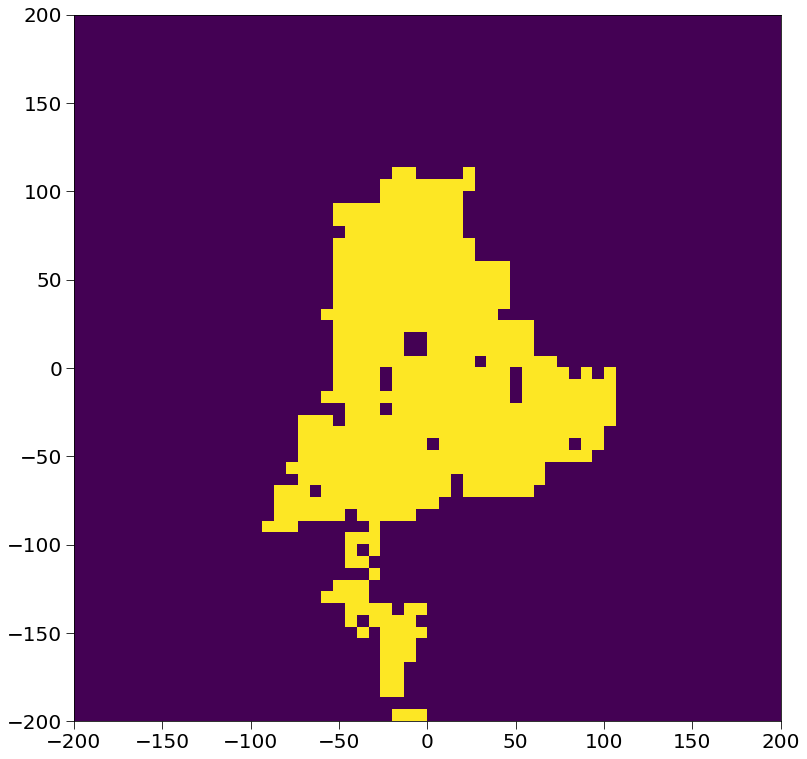

23999.99999999993


In [17]:
#PC1 = reduced_cartesianv[:,0]
#PC2 = reduced_cartesianv[:,1]
#hist, xedges, yedges = np.histogram2d(PC1, PC2, bins=60, range=[[-200, 200], [-200, 200]])
#over_threshold = hist > 1
#area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
#ax = plt.figure(figsize=(15,13)).add_subplot(111)
#ax.imshow(
#    over_threshold, interpolation='nearest',
#    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#plt.show()
#print(area)

total volume of virion trajectory: 75196.2384071719


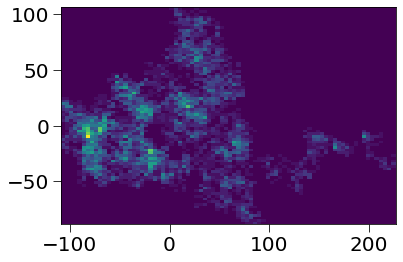

In [18]:
h, xedges, yedges, _ = plt.hist2d(reduced_cartesianv[:, 0], reduced_cartesianv[:, 1],
                                  bins=80, density=False)
total_volume = np.sum(h * np.diff(xedges).reshape(-1, 1) * np.diff(yedges).reshape(1, -1))
print("total volume of virion trajectory:", total_volume)

In [19]:
#this is a method of quantifying the PCA area accessed. It is only useful for qualitative comparisons.
#the numbers themselves are unitless, and all the bins must have the same number
#I am setting a small threshold to exclude null pixels from the area calculation
#if I set the threshold too high it will exclude space that is accessed at a low probability
hist, xedges, yedges = np.histogram2d(pca_glycosylated[:,0], pca_glycosylated[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("total area of glycosylated trajectories:", area)
hist, xedges, yedges = np.histogram2d(pca_unglycosylated[:,0], pca_unglycosylated[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("total area of unglycosylated trajectories:", area)
hist, xedges, yedges = np.histogram2d(reduced_cartesianv[:,0], reduced_cartesianv[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("total area of virion trajectory:", area)
hist, xedges, yedges = np.histogram2d(reduced_cartesiang1[:,0], reduced_cartesiang1[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("area of glycosylated trajectory 1:", area)
hist, xedges, yedges = np.histogram2d(reduced_cartesiang2[:,0], reduced_cartesiang2[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("area of glycosylated trajectory 2:", area)
hist, xedges, yedges = np.histogram2d(reduced_cartesiang3[:,0], reduced_cartesiang3[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("area of glycosylated trajectory 3:", area)
hist, xedges, yedges = np.histogram2d(reduced_cartesianu1[:,0], reduced_cartesianu1[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("area of unglycosylated trajectory 1:", area)
hist, xedges, yedges = np.histogram2d(reduced_cartesianu2[:,0], reduced_cartesianu2[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("area of unglycosylated trajectory 2:", area)
hist, xedges, yedges = np.histogram2d(reduced_cartesianu3[:,0], reduced_cartesianu3[:,1], bins=60, range=[[-200, 200], [-200, 200]])
over_threshold = hist > 1
area = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print("area of unglycosylated trajectory 3:", area)

total area of glycosylated trajectories: 35155.55555555545
total area of unglycosylated trajectories: 41822.2222222221
total area of virion trajectory: 23999.99999999993
area of glycosylated trajectory 1: 25466.666666666595
area of glycosylated trajectory 2: 19244.444444444387
area of glycosylated trajectory 3: 17333.333333333285
area of unglycosylated trajectory 1: 27866.666666666584
area of unglycosylated trajectory 2: 27377.777777777697
area of unglycosylated trajectory 3: 19555.5555555555


In [20]:
(27866+27377+19555)/3

24932.666666666668

In [21]:
(25466+19244+17333)/3

20681.0

Areas: b-box = 114.5797, points =   7.8001


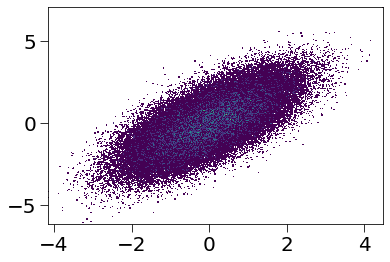

7.800126875291629


In [22]:
#def area_of_points(points, grid_size = [1000, 1000]):
#   """ 
#   Returns the area covered by N 2D-points provided in a 'points' array
#       points = [ (x1,y1), (x2,y2), ... , (xN, yN) ]
#   'grid_size' gives the number of grid cells in x and y direction the
#   'points' bounding box is divided into for calculation of the area. 
#   Larger 'grid_size' values mean smaller grid cells, higher precision 
#   of the area calculation and longer runtime.  
#         area_of_points() requires installed matplotlib module. """
#   import matplotlib.pyplot as plt
#   import numpy as np
#   pts_x = [x for x,y in points]
#   pts_y = [y for x,y in points]
#   pts_bb_area = (max(pts_x)-min(pts_x))*(max(pts_y)-min(pts_y))
#   h2D,_,_,_ = plt.hist2d( pts_x, pts_y, bins = grid_size, cmin=1)
#   numberOfWhiteBins = np.count_nonzero(np.isnan(h2D))
#   numberOfAll2Dbins = h2D.shape[0]*h2D.shape[1] 
#   areaFactor = 1.0 - numberOfWhiteBins/numberOfAll2Dbins
#   pts_pts_area = areaFactor * pts_bb_area
#   print(f'Areas: b-box = {pts_bb_area:8.4f}, points = {pts_pts_area:8.4f}')
#   plt.show()
#   return pts_pts_area
#:def area_of_points(points, grid_size = [1000, 1000])

#import numpy as np
#np.random.seed(12345)
#x =     np.random.normal(size=100000)
#y = x + np.random.normal(size=100000)
#pts = [[xi,yi] for xi,yi in zip(x,y)]
#print(area_of_points(pts))
# ^-- prints: Areas: b-box = 114.5797, points =   7.8001
# ^-- prints: 7.800126875291629

Areas: b-box = 111768.5156, points = 4138.7881


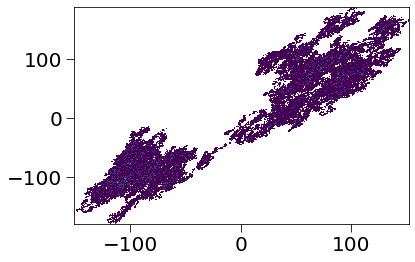

4138.788133593751


In [23]:
#x =     reduced_cartesianu1[:,0]
#y = reduced_cartesianu1[:,0] + reduced_cartesianu1[:,1]
#pts = [[xi,yi] for xi,yi in zip(x,y)]
#print(area_of_points(pts))

Areas: b-box = 119469.3516, points = 11192.9641


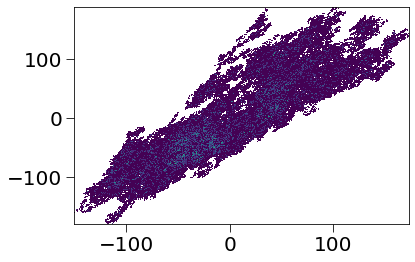

11192.964078539066


In [24]:
#x =     pca_unglycosylated[:,0]
#y = pca_unglycosylated[:,0] + pca_unglycosylated[:,1]
#pts = [[xi,yi] for xi,yi in zip(x,y)]
#print(area_of_points(pts))